In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from matplotlib import cm
from haversine import haversine, Unit
import geopandas as gpd


In [2]:
filtered_whether_data = pd.read_csv('filtered_precipitation_data_2012_2022_by_station.csv')

filtered_locations = pd.read_csv('filtered_RJ_lat_long_data.csv')
print(filtered_locations)


                  CITY STATE       LONG        LAT     ALT
0       Angra Dos Reis    RJ -44.319627 -23.009116    7.64
1              Aperibé    RJ -42.104917 -21.619422   65.93
2             Araruama    RJ -42.341096 -22.877438   12.10
3                Areal    RJ -43.101070 -22.236912  450.69
4   Armação Dos Búzios    RJ -41.887749 -22.757764   10.97
..                 ...   ...        ...        ...     ...
87           Três Rios    RJ -43.211609 -22.117448  274.13
88             Valença    RJ -43.704844 -22.244719  550.86
89           Varre-Sai    RJ -41.863295 -20.929298  808.03
90           Vassouras    RJ -43.663874 -22.409008  436.12
91       Volta Redonda    RJ -44.093522 -22.509968  377.26

[92 rows x 5 columns]


In [3]:
print(filtered_whether_data.dtypes)


ESTACAO               object
lat                  float64
lon                  float64
lvl                  float64
week                   int64
precipitation_avg    float64
precipitation_max    float64
dtype: object


In [4]:
filtered_whether_data = filtered_whether_data[filtered_whether_data['week'] == 201201]
print(filtered_whether_data)

     ESTACAO        lat        lon      lvl    week  precipitation_avg  \
0       A601 -22.800000 -43.683333    33.00  201201          14.171429   
577     A602 -23.050000 -43.600000     9.70  201201           2.171429   
1160    A603 -22.589722 -43.282222    33.00  201201                NaN   
1736    A604 -21.566667 -41.950000    35.00  201201           7.514286   
2281    A606 -22.983333 -42.016667     4.00  201201           2.114286   
2853    A607 -21.716667 -41.350000    25.00  201201           6.371429   
3427    A608 -22.383333 -41.816667    32.00  201201           4.371429   
3992    A609 -22.450000 -44.450000   439.89  201201           5.257143   
4548    A610 -22.481667 -43.291389  1777.00  201201           9.685714   
5039    A611 -22.350000 -43.700000   367.00  201201           6.571429   
5563    A618 -22.448889 -42.987222   980.00  201201           4.571429   
6146    A619 -23.223333 -44.726667     5.00  201201           0.200000   
6708    A621 -22.860833 -43.411111    

In [5]:

filtered_whether_data = filtered_whether_data.dropna(subset=['precipitation_avg'])

# Step 2: Define grid space and generate grid
grid_space = 0.01  # 0.01 degrees
grid_lon = np.arange(filtered_locations['LONG'].min(), filtered_locations['LONG'].max(), grid_space)
grid_lat = np.arange(filtered_locations['LAT'].min(), filtered_locations['LAT'].max(), grid_space)

# Step 3: Create a grid of points
all_lons, all_lats = np.meshgrid(grid_lon, grid_lat)
grid_points = np.column_stack((all_lats.ravel(), all_lons.ravel()))  # Shape (num_points, 2)

print(grid_points)

[[-23.21941361 -44.7108585 ]
 [-23.21941361 -44.7008585 ]
 [-23.21941361 -44.6908585 ]
 ...
 [-20.92941361 -41.0708585 ]
 [-20.92941361 -41.0608585 ]
 [-20.92941361 -41.0508585 ]]


In [6]:
def haversine_distance(point1, point2):
    """Calculate Haversine distance between two points."""
    return haversine(point1, point2, unit=Unit.KILOMETERS)

In [7]:

def idw_interpolation_haversine(grid_points, data_points, values, power=2):
    """IDW interpolation using Haversine distance."""
    interpolated_values = []
    
    for grid_point in grid_points:
        # Calculate distances to all data points
        distances = np.array([haversine(grid_point, data_point) for data_point in data_points])
        
        # Avoid zero distances for points at the same location
        distances[distances == 0] = np.nan  # Set to NaN to avoid division by zero
        
        # Inverse distance weighting calculation
        weights = 1 / distances**power
        weights[np.isnan(weights)] = 0  # Set weights to 0 for NaN distances
        
        # Weighted average of values
        weighted_values = np.dot(weights, values)
        sum_weights = np.sum(weights)
        
        # Avoid division by zero in sum_weights
        interpolated_value = weighted_values / sum_weights if sum_weights > 0 else 0
        interpolated_values.append(interpolated_value)

    return np.array(interpolated_values)

# Step 5: Extract data points (latitude, longitude) and values (precipitation_avg)
data_points = filtered_whether_data[['lat', 'lon']].values
values = filtered_whether_data['precipitation_avg'].values

# Step 6: Perform interpolation
interpolated_precipitation = idw_interpolation_haversine(grid_points, data_points, values)

# Step 7: Create a DataFrame for the interpolated results
itrp = pd.DataFrame({
    'lat': all_lats.ravel(),
    'lng': all_lons.ravel(),
    'interpolated_precipitation': interpolated_precipitation
})

# Step 8: Display or save the interpolated DataFrame
print(itrp)

             lat        lng  interpolated_precipitation
0     -23.219414 -44.710859                    0.209131
1     -23.219414 -44.700859                    0.223528
2     -23.219414 -44.690859                    0.245089
3     -23.219414 -44.680859                    0.273913
4     -23.219414 -44.670859                    0.310049
...          ...        ...                         ...
84405 -20.929414 -41.090859                    5.764284
84406 -20.929414 -41.080859                    5.758849
84407 -20.929414 -41.070859                    5.753446
84408 -20.929414 -41.060859                    5.748075
84409 -20.929414 -41.050859                    5.742737

[84410 rows x 3 columns]


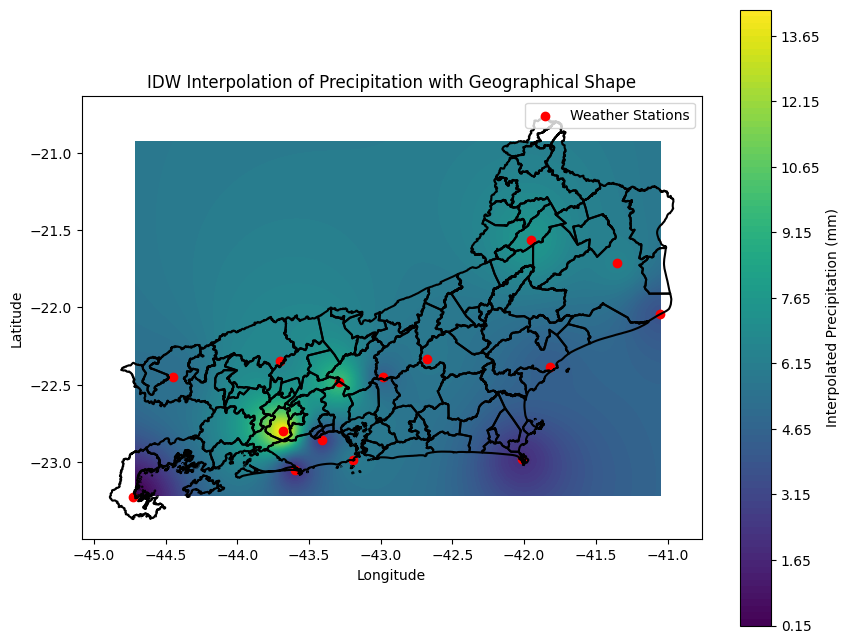

In [8]:
# Step 8: Load the shapefile
# Replace 'path_to_your_shapefile.shp' with the actual path to your shapefile
shapefile_path = 'rio-de-janeiro_.geojson'  # Example: 'bengaluru.shp'
gdf = gpd.read_file(shapefile_path)

# Step 9: Plotting the results with the geographical shape
plt.figure(figsize=(10, 8))
# Plot the shapefile boundary
gdf.boundary.plot(ax=plt.gca(), color='black')  # You can customize the color and style

# Create contour plot
contour = plt.tricontourf(itrp['lng'], itrp['lat'], itrp['interpolated_precipitation'], levels=100, cmap='viridis')
plt.colorbar(contour, label='Interpolated Precipitation (mm)')

# Plot original weather stations
plt.scatter(filtered_whether_data['lon'], filtered_whether_data['lat'], c='red', marker='o', label='Weather Stations')

plt.title('IDW Interpolation of Precipitation with Geographical Shape')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()